Recommendation System

Data Description:

Unique ID of each anime.
Anime title.
Anime broadcast type, such as TV, OVA, etc.
anime genre.
The number of episodes of each anime.
The average rating for each anime compared to the number of users who gave ratings.


Number of community members for each anime.
Objective:
The objective of this assignment is to implement a recommendation system using cosine similarity on an anime dataset. 
Dataset:
Use the Anime Dataset which contains information about various anime, including their titles, genres,No.of episodes and user ratings etc.

Tasks:

Data Preprocessing:

Load the dataset into a suitable data structure (e.g., pandas DataFrame).
Handle missing values, if any.
Explore the dataset to understand its structure and attributes.

Feature Extraction:

Decide on the features that will be used for computing similarity (e.g., genres, user ratings).
Convert categorical features into numerical representations if necessary.
Normalize numerical features if required.

Recommendation System:

Design a function to recommend anime based on cosine similarity.
Given a target anime, recommend a list of similar anime based on cosine similarity scores.
Experiment with different threshold values for similarity scores to adjust the recommendation list size.

Evaluation:

Split the dataset into training and testing sets.
Evaluate the recommendation system using appropriate metrics such as precision, recall, and F1-score.
Analyze the performance of the recommendation system and identify areas of improvement.


In [17]:
# Load the dataset 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
anime_data=pd.read_csv("anime.csv")
anime_data=anime_data.drop(["name"],axis=1)
anime_data

,anime_id,genre,type,episodes,rating,members
0,32281,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...
12289,9316,Hentai,OVA,1,4.15,211
12290,5543,Hentai,OVA,1,4.28,183
12291,5621,Hentai,OVA,4,4.88,219
12292,6133,Hentai,OVA,1,4.98,175


In [19]:
# Replacing the "Unknown" values to 0
anime_data['episodes'].replace("Unknown",0,inplace=True)
# Sorting the data_values based on "Anime_ID"
#anime_data.sort_values(["anime_id"],ignore_index=True)

In [20]:
# Explore the Dataset 
print(f'Shape of the Datasets :-{anime_data.shape}')
anime_data.describe()


Shape of the Datasets :-(12294, 6)


,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [21]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   genre     12232 non-null  object 
 2   type      12269 non-null  object 
 3   episodes  12294 non-null  object 
 4   rating    12064 non-null  float64
 5   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 576.4+ KB


In [22]:
# Handle missing values 
anime_data.isnull().sum()

anime_id      0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [23]:
# Filling the missing values 
# Replacing the NAN values of ratings with "0" 
anime_data["rating"].fillna(0,inplace=True)

# filling the missing values with mean/median/mode
anime_data["genre"].fillna(anime_data["genre"].mode()[0],inplace=True)
anime_data["type"].fillna(anime_data["type"].mode()[0],inplace=True)                     

In [24]:
# verifying missing values are left or not 
anime_data.isnull().sum()

anime_id    0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [25]:
# converting the values of "ratings" (float into int) for better visualization
anime_data["rating"]=anime_data["rating"].astype(int)
# Number of ratings & counts 
anime_data['rating'].value_counts().sort_index()

rating
0      230
1        2
2       22
3      211
4      752
5     2372
6     4784
7     3294
8      603
9       23
10       1
Name: count, dtype: int64

<Axes: xlabel='rating'>

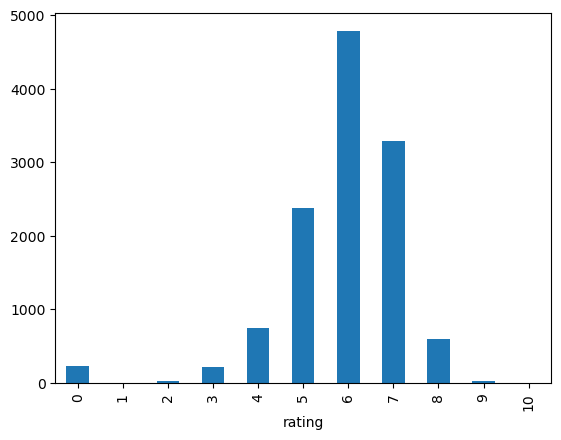

In [26]:
# Plot the Number of ratings & counts 
anime_data['rating'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='rating', ylabel='Density'>

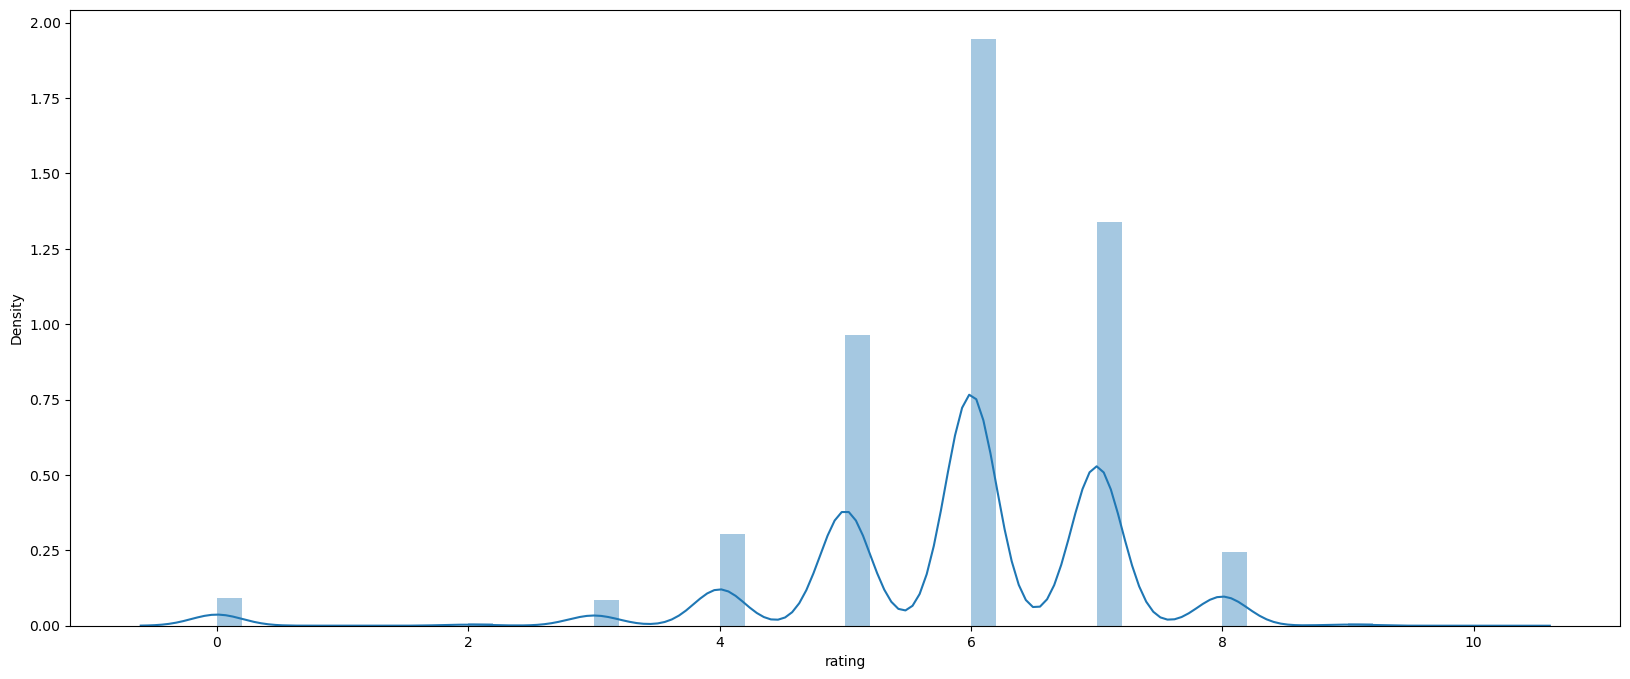

In [27]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(20,8))
sns.distplot(anime_data.rating)

# Feature Extraction 

In [28]:
#We'll use genres and user ratings to compute similarity.Convert categorical features into numerical representations
# Convert genres to numerical representations
from sklearn.preprocessing import MultiLabelBinarizer,StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(anime_data['genre'].str.split(', '))
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Normalize numerical features
scaler = StandardScaler()
anime_data['rating'] = scaler.fit_transform(anime_data[['rating']])

# Combine features for similarity computation
features_df = pd.concat([anime_data[['anime_id', 'rating']], genres_df], axis=1)

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(features_df.drop('anime_id', axis=1))

In [29]:
# function recommendation for anime 
def recommend_anime(anime_id,cosine_sim=cosine_sim,anime_data=anime_data,top_n=10,similarity_threshold=0.5):
    try :
        idx = anime_data.index[anime_data["anime_id"]==anime_id][0]
    except IndexError:
        return "Anime_id does not exist"
    
    # Get the similarity scores for the given anime 
    sim_scores = cosine_sim[idx]
    
    # sort the anime based on similarity scores
    sim_sort=sim_scores.argsort()[::-1]
    
    # Get the top n recommendation 
    top_recom=sim_sort[1:top_n+1]
    
    return anime_data.iloc[top_recom]
recommendations = recommend_anime(anime_id=1, top_n=5, similarity_threshold=0.5)
print(recommendations[['anime_id','genre','type' ,'rating','episodes']])

      anime_id                                            genre     type  \
1465      4037  Action, Adventure, Comedy, Drama, Sci-Fi, Space  Special   
1398      2203          Action, Adventure, Drama, Sci-Fi, Space       TV   
3057      2717          Action, Adventure, Drama, Sci-Fi, Space       TV   
1073      2202          Action, Adventure, Drama, Sci-Fi, Space    Movie   
551        400         Action, Adventure, Comedy, Sci-Fi, Space       TV   

        rating episodes  
1465  0.838733        1  
1398  0.838733       22  
3057  0.838733       24  
1073  0.838733        1  
551   0.838733       24  


In [30]:
# Experiment with Threshold Values
# Example usage with different similarity thresholds
recommendations = recommend_anime(anime_id=1, top_n=5, similarity_threshold=0.3)
print(recommendations[['anime_id','type','genre', 'rating','episodes']])

recommendations = recommend_anime(anime_id=1, top_n=5, similarity_threshold=0.7)
print(recommendations[['anime_id', 'type', 'genre', 'rating','episodes']])

      anime_id     type                                            genre  \
1465      4037  Special  Action, Adventure, Comedy, Drama, Sci-Fi, Space   
1398      2203       TV          Action, Adventure, Drama, Sci-Fi, Space   
3057      2717       TV          Action, Adventure, Drama, Sci-Fi, Space   
1073      2202    Movie          Action, Adventure, Drama, Sci-Fi, Space   
551        400       TV         Action, Adventure, Comedy, Sci-Fi, Space   

        rating episodes  
1465  0.838733        1  
1398  0.838733       22  
3057  0.838733       24  
1073  0.838733        1  
551   0.838733       24  
      anime_id     type                                            genre  \
1465      4037  Special  Action, Adventure, Comedy, Drama, Sci-Fi, Space   
1398      2203       TV          Action, Adventure, Drama, Sci-Fi, Space   
3057      2717       TV          Action, Adventure, Drama, Sci-Fi, Space   
1073      2202    Movie          Action, Adventure, Drama, Sci-Fi, Space   
551    